## Code for improving low quality image to high quality image using U-Net in  CNN

### Importing libraries

In [7]:
import numpy as np
import tensorflow as tf
import keras
import cv2
from keras.models import Sequential
from tensorflow.keras.utils import img_to_array
import os
from tqdm import tqdm
import re
import matplotlib.pyplot as plt

### Loading Data

In [8]:
# to get the files in proper order
def sorted_alphanumeric(data):  
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [convert(c) for c in re.split('([0-9]+)',key)]
    return sorted(data,key = alphanum_key)
# defining the size of the image
SIZE = 256
high_img = []
path = "dataset\Raw Data\high_res"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):    
    if i == '855.jpg':
        break
    else:    
        img = cv2.imread(path + '/'+i,1)
        # open cv reads images in BGR format so we have to convert it to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        high_img.append(img_to_array(img))


low_img = []
path = "dataset\Raw Data\low_res"
files = os.listdir(path)
files = sorted_alphanumeric(files)
for i in tqdm(files):
    if i == '855.jpg':
        break
    else: 
        img = cv2.imread(path + '/'+i,1)

        #resizing image
        img = cv2.resize(img, (SIZE, SIZE))
        img = img.astype('float32') / 255.0
        low_img.append(img_to_array(img))

100%|████████████████████████████████████████████████████████████████████████████████| 855/855 [00:21<00:00, 39.25it/s]


### Data Vizualization

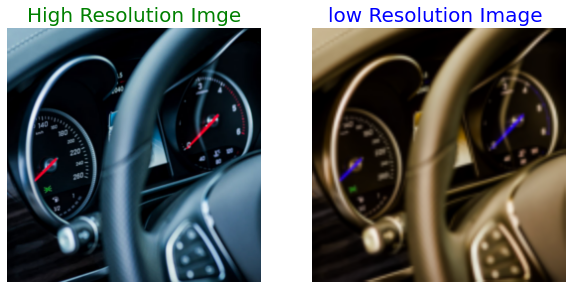

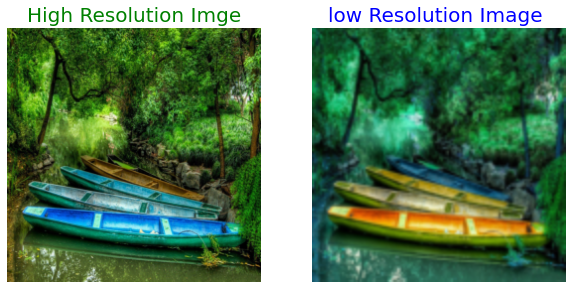

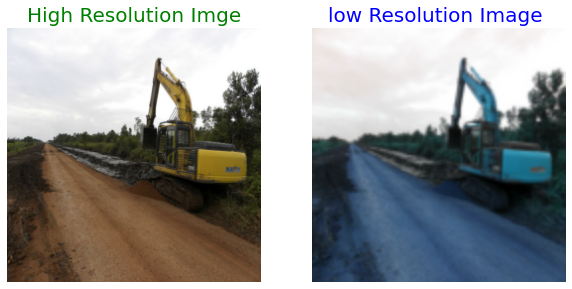

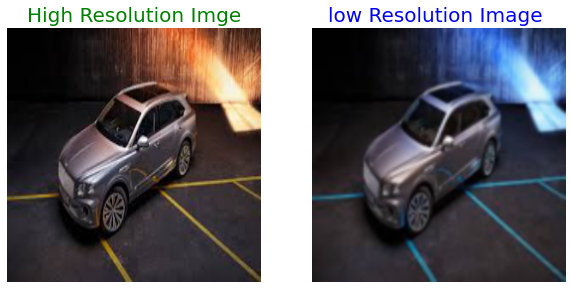

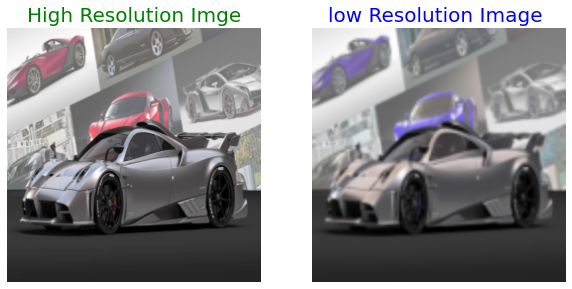

In [9]:
for i in range(5):
    a = np.random.randint(0,855)
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.title('High Resolution Imge', color = 'green', fontsize = 20)
    plt.imshow(high_img[a])
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.title('low Resolution Image ', color = 'blue', fontsize = 20)
    plt.imshow(low_img[a])
    plt.axis('off')

### Slicing and Reshaping the Image

In [10]:
train_high_image = high_img[:700]
train_low_image = low_img[:700]
train_high_image = np.reshape(train_high_image,(len(train_high_image),SIZE,SIZE,3))
train_low_image = np.reshape(train_low_image,(len(train_low_image),SIZE,SIZE,3))

validation_high_image = high_img[700:830]
validation_low_image = low_img[700:830]
validation_high_image= np.reshape(validation_high_image,(len(validation_high_image),SIZE,SIZE,3))
validation_low_image = np.reshape(validation_low_image,(len(validation_low_image),SIZE,SIZE,3))


test_high_image = high_img[830:]
test_low_image = low_img[830:]
test_high_image= np.reshape(test_high_image,(len(test_high_image),SIZE,SIZE,3))
test_low_image = np.reshape(test_low_image,(len(test_low_image),SIZE,SIZE,3))

print("Shape of training images:",train_high_image.shape)
print("Shape of test images:",test_high_image.shape)
print("Shape of validation images:",validation_high_image.shape)

Shape of training images: (700, 256, 256, 3)
Shape of test images: (25, 256, 256, 3)
Shape of validation images: (130, 256, 256, 3)


### Defining Model

In [11]:
from keras import layers
def down(filters , kernel_size, apply_batch_normalization = True):
    downsample = tf.keras.models.Sequential()
    downsample.add(layers.Conv2D(filters,kernel_size,padding = 'same', strides = 2))
    if apply_batch_normalization:
        downsample.add(layers.BatchNormalization())
    downsample.add(keras.layers.LeakyReLU())
    return downsample


def up(filters, kernel_size, dropout = False):
    upsample = tf.keras.models.Sequential()
    upsample.add(layers.Conv2DTranspose(filters, kernel_size,padding = 'same', strides = 2))
    if dropout:
        upsample.dropout(0.2)
    upsample.add(keras.layers.LeakyReLU())
    return upsample

def model():
    inputs = layers.Input(shape= [SIZE,SIZE,3])
    d1 = down(128,(3,3),False)(inputs)
    d2 = down(128,(3,3),False)(d1)
    d3 = down(256,(3,3),True)(d2)
    d4 = down(512,(3,3),True)(d3)
    
    d5 = down(512,(3,3),True)(d4)
    #upsampling
    u1 = up(512,(3,3),False)(d5)
    u1 = layers.concatenate([u1,d4])
    u2 = up(256,(3,3),False)(u1)
    u2 = layers.concatenate([u2,d3])
    u3 = up(128,(3,3),False)(u2)
    u3 = layers.concatenate([u3,d2])
    u4 = up(128,(3,3),False)(u3)
    u4 = layers.concatenate([u4,d1])
    u5 = up(3,(3,3),False)(u4)
    u5 = layers.concatenate([u5,inputs])
    output = layers.Conv2D(3,(2,2),strides = 1, padding = 'same')(u5)
    return tf.keras.Model(inputs=inputs, outputs=output)

model = model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 128, 128, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 sequential_1 (Sequential)      (None, 64, 64, 128)  147584      ['sequential[0][0]']             
                                                                                              

### Compiling the model

In [12]:
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), loss = 'mean_absolute_error',
              metrics = ['acc'])

### Fitting the model

In [ ]:
model.fit(train_low_image, train_high_image, epochs = 10, batch_size = 1,
          validation_data = (validation_low_image,validation_high_image))

Epoch 1/10
700/700 [==============================] - 326s 454ms/step - loss: 0.0412 - acc: 0.6887 - val_loss: 0.0256 - val_acc: 0.8376
Epoch 2/10
700/700 [==============================] - 354s 506ms/step - loss: 0.0242 - acc: 0.7816 - val_loss: 0.0236 - val_acc: 0.7303
Epoch 3/10
700/700 [==============================] - 332s 474ms/step - loss: 0.0222 - acc: 0.7990 - val_loss: 0.0223 - val_acc: 0.8385
Epoch 4/10
700/700 [==============================] - 237s 339ms/step - loss: 0.0204 - acc: 0.8233 - val_loss: 0.0198 - val_acc: 0.8385
Epoch 5/10
700/700 [==============================] - 237s 339ms/step - loss: 0.0194 - acc: 0.8257 - val_loss: 0.0329 - val_acc: 0.7268
Epoch 6/10
700/700 [==============================] - 235s 336ms/step - loss: 0.0192 - acc: 0.8357 - val_loss: 0.0184 - val_acc: 0.9049
Epoch 7/10
306/700 [============>.................] - ETA: 2:10 - loss: 0.0187 - acc: 0.8371

### Accuracy

In [ ]:
Unet_test_score=model.evaluate(test_high_image,test_low_image,verbose = 0)
print('UNet Test loss:', Unet_test_score[0])
print('UNet Test accuracy:', Unet_test_score[1])

### Prediction

In [ ]:
def plot_images(high,low,predicted):
    plt.figure(figsize=(15,15))
    plt.subplot(1,3,1)
    plt.title('High resolution Image', color = 'green', fontsize = 15)
    plt.imshow(high)
    plt.subplot(1,3,2)
    plt.title('Low resolution Image ', color = 'yellow', fontsize = 15)
    plt.imshow(low)
    plt.subplot(1,3,3)
    plt.title('Predicted High resolution Image ', color = 'Red', fontsize = 15)
    plt.imshow(predicted)
   
    plt.show()

for i in range(5):
    a = np.random.randint(0,25)
    predicted = np.clip(model.predict(test_low_image[a].reshape(1,SIZE, SIZE,3)),0.0,1.0).reshape(SIZE, SIZE,3)
    plot_images(test_high_image[a],test_low_image[a],predicted)